# Overview
`Desideratum`: Learn formulas for the blocking probability$^{\lambda_0}$ of the G/G/C/C$^{\lambda_1}$ queue via stochastic simulation$^{\lambda_2}$ and machine learning$^{\lambda_3}$ that outperm approximations derived from heavy traffic limit theory$^{\lambda_4}$.

${\lambda_0}$: Blocking occurs when a new request arrives at a time where all available servers are currently busy. Hence, given information about our queue, we're interested in learning the blocking probability as a function of $\rho$ and C.
  * $\rho = \frac{\lambda}{\mu}$ 

${\lambda_1}$: This notation is common in Queueing theory. By definition, the queueing process is described by a series of symbols and slashes: A/B/X/Y/Z
  * A $\equiv$ indicates the interarrival distribution
  * B $\equiv$ the service pattern as described by the probability distribution for service time.
  * X $\equiv$ the number of parallel service channels
  * Y $\equiv$ the restriction on system capacit
  * Z $\equiv$ the queue discipline, such as first-come-first serve (FCFS/FIFO), etc.


${\lambda_2}$: This refers to sampling-based computational methods. Often referred to as Monte Carlo Algorithms/Simulation as well.

${\lambda_3}$: ML is typically classified into three categories of learning, though this may need revision: supervised, unsupervised, and reinforced.

${\lambda_4}$: <a href="https://en.wikipedia.org/wiki/Heavy_traffic_approximation">Heavy Traffic Limit Theory</a> is the matching of a queueing model with a diffusion process under some limiting conditions on the model's paramters.

<span style="color: #FF0000">All else below this section is a matter of implementation, experimenation, and general rumination. Otherwise known as "too long, don't read" (TLDR).</span>
    
## Pontifications
- Using a linear model to learn blocking probabilities produces negative blocking probabilities. Definitely don't want this. Should explore kernel density estimation.
- Can I learn the exact function when the data isn't noisy? Investigate this. 
- Tractable in a ML sense but intepretable in a probabilistic sense.

## General Rumination on the Fundamentals of Queueing Theory and Erlang's Blocking Formula
The notion of a `blocking probability` seems to be capturing the likelihood that a system will block as time approaches infinity. Ideally, we might want to find some configuration of our system such that this probability is below some tolerable threshold.

### Erlang's Loss Formula ($M/M/c/c$)
The special case of the truncated queue $M/M/c/K$ with $K=c$, that is, where no line is allowed to form, gives rise to a stationary distribution known as Erlang's first formula:
$$
p_n = \frac{(\lambda / \mu)^n}{n!} \Big/ \left( \sum_{i=0}^{c}\frac{(\lambda / \mu)^i}{i!} \right) \;,\; (0 \leq n \leq c)
$$
The probability of a full system at any time in steady state is called `Erlang's loss formula` or the `Erlang-B formula`, which we denote as $p_c$. However, the great importance of this formula lies in the very surprising fact that it is valid for <em>any $M/G/c/c$</em>, independent of the form of the service-time distribution.

### Potentially Relevant Resources
* <a href="https://www.sciencedirect.com/science/article/pii/S0096300395002162">On Interpolating Between Probability Distributions</a> by Faruk H. Bursal

In [206]:
import numpy as np
from functools import partial
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from matplotlib import pyplot as plt


def compute_erlang_blocking_probability(
    arrival_rate: float,
    service_rate: float,
    number_of_servers: int
):
    rho = arrival_rate / service_rate
    blocking_probability = 1
    
    for i in range(number_of_servers + 1):
        blocking_probability = rho * blocking_probability / (rho * blocking_probability + i)
        
    return (rho, blocking_probability)

def compute_erlang_blocking_probability_rho(
    rho: float,
    number_of_servers: int
):
    blocking_probability = 1
    
    for i in range(number_of_servers + 1):
        blocking_probability = rho * blocking_probability / (rho * blocking_probability + i)
    
    return blocking_probability

erlang_b = compute_erlang_blocking_probability


def generate_uniform_data(
    arrival_rate_interval: tuple[float, float],
    service_rate_interval: tuple[float, float],
    max_servers: int,
    data_points: int
):
    # Arrival Rate is λ, Service Rate is μ
    # Here, we're assuming we have a handle on the mean of the interarrival and service distribution
    arrivals_mesh = np.random.uniform(arrival_rate_interval[0], arrival_rate_interval[1], data_points)
    services_mesh = np.random.uniform(service_rate_interval[0], service_rate_interval[1], data_points)
    servers_mesh = np.random.randint(1, max_servers, data_points)
    X = np.zeros((data_points, 3))
    y = np.zeros(data_points)
    
    # Given the mean of the interarrival distribution, mean of the service distribution, and the number of servers
    # used in the ith example, we can deterministically compute the blocking probability.
    for i in range(data_points):
        cur_server_count = servers_mesh[i]
        cur_arrival_rate = arrivals_mesh[i]
        cur_service_rate = services_mesh[i]
        
        # Save the blocking probability and the other random variables for the ML problem later
        rho, bp = erlang_b(cur_arrival_rate, cur_service_rate, cur_server_count)
        X[i, 0] = cur_arrival_rate
        X[i, 1] = cur_service_rate
        X[i, 2] = cur_server_count
        y[i] = bp
    
    return X,y


def simulate_queue(N, K, arrival, service):
    """Simulate a queueing system with N customers and K servers.
    
    K is servers and threshold in terms of blocking. It is a blocking queue.
    Arrival time + service time if not blocked. Arrival time if blocked.
    From the # of departures we can get the queue length. Blocking means you
    don't get service at all.

    Want to calculate the fraction of people who get blocked via simulation.
    Ideally we want the blocking probability. Using the estimate as a data point.
    """
    queue_upon_arrival = np.zeros(N);
    blocked = np.zeros(N);
    blocked2 = np.zeros(N);
    # It is in terms of interarrival times. 
    arrival_times = np.cumsum(arrival);
    departure_times =  np.zeros(N);

    # Computing the queue length upon arrival
    queue_upon_arrival[0] = 0;
    blocked[0] = 0;
    blocked2[0] = 0;
    new_index = 0
    num_departed = 0
    departure_times[0] = arrival_times[0] + service[0];
    for i in range(new_index,N-1):
        count = 0 ;
        #print(new_index)
        for j in range(1,i):
            num_departed = num_departed + (departure_times[j] < arrival_times[i+1])
            count = count + (departure_times[j] - arrival_times[i] > 0)
   
        queue_upon_arrival[i] = count
        new_index = int(np.max(num_departed - blocked2[i] - K,0))
        departure_times[i] = arrival_times[i] + service[i]*(count < K )
        blocked[i] = (count < K)
        blocked2[i] = blocked2[i-1] + (1-blocked[i])
    mean_blocked = 1-np.mean(blocked)
    mean_queue = np.mean(queue_upon_arrival)
    return mean_blocked,mean_queue

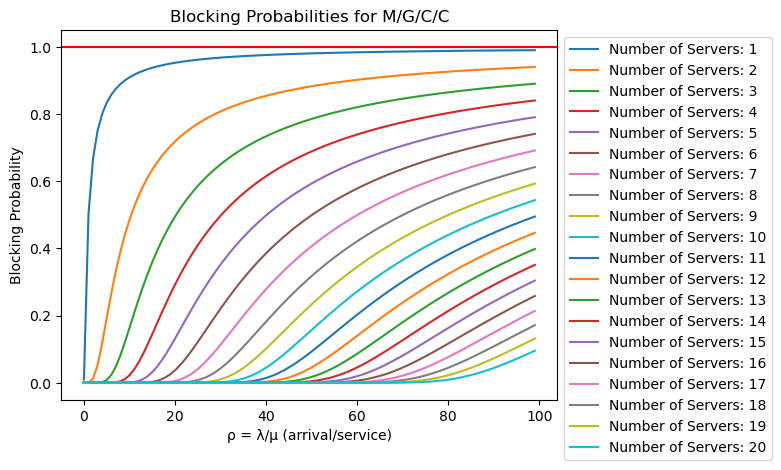

In [207]:
rho_grid = np.arange(.01, 100.)
MAX_SERVERS = 100
blocking_probabilities = np.array([
    compute_erlang_blocking_probability_rho(rho_grid, server) for server in range(1, MAX_SERVERS + 1, 5)
])

# Setting Up Plot
plt.title(f"Blocking Probabilities for M/G/C/C")
plt.xlabel("ρ = λ/μ (arrival/service)")
plt.ylabel("Blocking Probability")
plt.axhline(y=1, color='r', linestyle='-')

# Overlap blocking probabilities for same rhos and various servers
[plt.plot(data, label=f"Number of Servers: {ndx}") for ndx, data in enumerate(blocking_probabilities, start=1)]

# Show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Plausible Approaches
Fundamentally, we care about learning the `blocking probability` for the G/G/C/C class of queueing systems. Since we're taking a data-driven approach, we want to leverage some techniques from machine learning to learn this blocking probability. Ultimately, whatever we learn must satisfy the following:
$$
\int_{0}^{\infty} LP_{block}(\textbf{x}) = 1
$$
where $LP_{block}(\textbf{x})$ is the learned blocking probability trained on data generated from stochastic simulation.

## Kernel Density Estimation
We'll investigate learning the blocking probability using the Tri-cube kernel since it is compact, smooth, and differentiable at the boundaries.

In [208]:
def epanechnikov_kernel(x):
    x_dot = np.dot(x, x)
    x_norm = np.sqrt(x_dot)
    indicator = int(x_norm <= 1)
    return .75 * (1 - x_dot) * indicator

def tricube_kernel(x):
    x_dot = np.dot(x, x)
    x_norm = np.sqrt(x_dot)
    indicator = int(x_norm <= 1)
    
    return (70/81) * (1 - x_norm**3)**3 * indicator

def gaussian_kernel(x):
    coeff = 1. / np.sqrt(2*np.pi)
    x_dot = np.dot(x, x)
    
    return coeff * np.exp(-x_dot / 2.)

def kernel_density_estimator_constructor(X: np.array, b: float, kernel):
    N = X.shape[1]
    normalizing_coeff = 1. / N*b
    
    def kernel_density_estimator(x: np.array):
        return normalizing_coeff * np.sum([kernel((x - X[:,j]) / b) for j in range(N)])
    
    return kernel_density_estimator

def normal_likelihood_constructor(mu: float, sigma: float):
    coeff = 1. / (np.sqrt(2*np.pi) * sigma)
    
    def normal_likelihood(x: np.array):
        normalized = (x - mu) / sigma
        return coeff * np.exp(-.5 * normalized ** 2)
    
    return normal_likelihood

## Thoughts on Kernel Density Estimation
I suspected the Gaussian kernel to approximate the underlying distribution (given that our ground truth is Gaussian) extremely well. However, it appears that the `Epanechnikov` and `Tri-Cube` kernels are a bit more robust at approximating the underlying distribution under normality assumptions. Of course, these are unvetted thoughts and my initial observations, so a more careful investigation is required.

Nevertheless, we could use this as a mechanism for learning the blocking probabilities in G/G/C/C queueing systems.

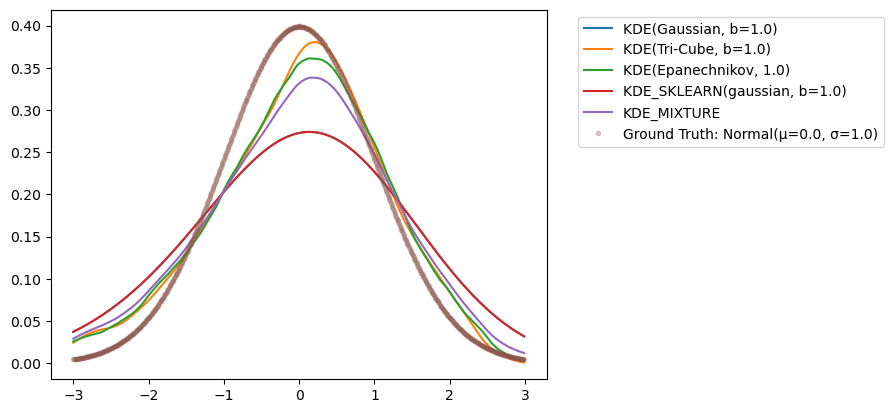

In [209]:
sample_size = np.power(2, 7)
loc, scale = 0., 1.
# Training data generation for cluster centers
X = np.array([np.random.normal(loc=loc, scale=scale) for _ in range(sample_size)])
X = X.reshape(1, X.shape[0])
domain = np.arange(-3., 3., step=.01)[:, np.newaxis]
normal_eval = normal_likelihood_constructor(loc, scale)
ground_truth = [normal_eval(xi) for xi in domain]
kernel_name = "gaussian"

for b in np.arange(1., 1.09, step=.1):
    # Build kernel density estimation constructors
    kde_gauss_eval = kernel_density_estimator_constructor(X, b, gaussian_kernel)
    kde_tricube_eval = kernel_density_estimator_constructor(X, b, tricube_kernel)
    kde_epanechnikov_eval = kernel_density_estimator_constructor(X, b, epanechnikov_kernel)
    
    # Evaluate each estimator for the given b
    kde_gauss = np.array([kde_gauss_eval(xi) for xi in domain])
    kde_tricube = np.array([kde_tricube_eval(xi) for xi in domain])
    kde_epanechnikov = np.array([kde_epanechnikov_eval(xi) for xi in domain])
    kde_sklearn_model = KernelDensity(kernel='gaussian', bandwidth=b).fit(X.T)
    kde_mixture = (kde_gauss + kde_tricube + kde_epanechnikov) / 3.
    kde_sklearn = np.exp(kde_sklearn_model.score_samples(domain))
    
    # Plot each approximation against the ground truth
    plt.plot(domain, kde_gauss, label=f"KDE(Gaussian, b={b:.1f})")
    plt.plot(domain, kde_tricube, label=f"KDE(Tri-Cube, b={b:.1f})")
    plt.plot(domain, kde_epanechnikov, label=f"KDE(Epanechnikov, {b:.1f})")
    plt.plot(domain, kde_sklearn, label=f"KDE_SKLEARN({kernel_name}, b={b:.1f})")
    plt.plot(domain, kde_mixture, label=f"KDE_MIXTURE")
    plt.plot(domain, ground_truth, ".", alpha=.3, label=f"Ground Truth: Normal(μ={loc}, σ={scale})")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

## Machine Learning Setup
Now, we formulate the mathematical optimization problem for linear regression, i.e.:
$$
\min_{w} \sum_{i=1}^{n}\left( R_i - w^T\bar{X}_i \right)^2
$$
where $w=(w_0, w_1, w_1, w_3)^T$, $\bar{X}_i=(1, X^{(1)}_i, X^{(2)}_i, X^{(3)}_i)$, and $R_i=\beta(X^{(3)}_i, \frac{X^{(2)}_i}{X^{(1)}_i})$. Furthermore, we require definitions for $X_i^{j}$.

In [332]:
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [211]:
arrival_interval = (1, 100)
service_interval = (1, 10)
num_servers = 100
data_points = 10_000

features, targets = generate_uniform_data(arrival_interval, service_interval, num_servers, data_points)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3)

In [276]:
# Train linear regression model on blocking probabilities
model = LinearRegression().fit(X_train, y_train)
model_kde = KernelDensity(kernel='gaussian', bandwidth=.01125).fit(X_train)

In [317]:
# Plot true blocking probability for fixed C as a function of rho
rhos = np.zeros(data_points)
servers = np.zeros(data_points)
bps = np.zeros(data_points)
predicted_bps = np.zeros(data_points)

# for ndx, (f, t) in enumerate(zip(features, targets)):
indices = np.argsort(X_test[:, 2])
X_test_sorted, y_test_sorted = X_test[indices], y_test[indices]
for ndx, (f, t) in enumerate(zip(X_test, y_test)):
    rhos[ndx] = f[0] / f[1]
    servers[ndx] = f[2]
    bps[ndx] = t
    predicted_bps[ndx] = model.predict(f.reshape(1, -1))

In [319]:
max_bp, min_bp = np.max(y_test_sorted), np.min(y_test_sorted)
print(f"Blocking Probabilities\nMax: {max_bp} -- Min: {min_bp}")

Blocking Probabilities
Max: 0.9849039309435942 -- Min: 5.252092710524216e-216


In [320]:
kde_estimates = np.exp(model_kde.score_samples(X_test))
kde_max_bp, kde_min_bp = np.max(kde_estimates), np.min(kde_estimates)
print(f"Blocking Probabilities\nMax: {kde_max_bp} -- Min: {kde_min_bp}")

Blocking Probabilities
Max: 0.984797331003522 -- Min: 0.0


In [336]:
# Flatten all true blocking probabilities and plot the differences between the 
# predicted blocking probability and the true blocking probability
bp_errors = mean_absolute_error(y_test_sorted, kde_estimates)
bp_errors

0.07095464313113044

In [311]:
error_threshold = .1
error_condition = bp_errors >= error_threshold
X_test_be, y_test_be = X_test[error_condition], y_test[error_condition]

In [312]:
np.exp(model_kde.score_samples(X_test_be[:10, :])), y_test_be[:10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.36373447, 0.47443902, 0.46225575, 0.65819984, 0.46898716,
        0.44548948, 0.71507077, 0.81882314, 0.40929061, 0.59371061]))

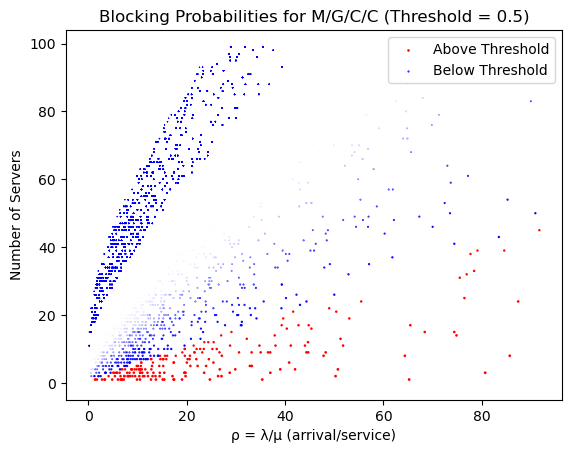

In [280]:
THRESHOLD = .5
HIGH_BLOCKING = "red"
LOW_BLOCKING = "blue"

plt.title(f"Blocking Probabilities for M/G/C/C (Threshold = {THRESHOLD})")
plt.xlabel("ρ = λ/μ (arrival/service)")
plt.ylabel("Number of Servers")

plt.scatter(
    rhos[bps >= THRESHOLD],
    servers[bps >= THRESHOLD],
    bps[bps >= THRESHOLD],
    label="Above Threshold",
    color=HIGH_BLOCKING
)
plt.scatter(
    rhos[bps < THRESHOLD],
    servers[bps < THRESHOLD],
    bps[bps < THRESHOLD],
    label="Below Threshold",
    color=LOW_BLOCKING
)
plt.legend()
plt.show()

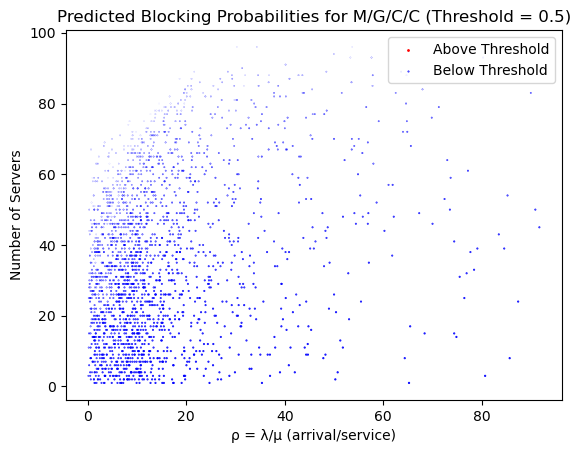

In [221]:
plt.title(f"Predicted Blocking Probabilities for M/G/C/C (Threshold = {THRESHOLD})")
plt.xlabel("ρ = λ/μ (arrival/service)")
plt.ylabel("Number of Servers")

plt.scatter(
    rhos[predicted_bps >= THRESHOLD],
    servers[predicted_bps >= THRESHOLD],
    predicted_bps[predicted_bps >= THRESHOLD],
    label="Above Threshold",
    color=HIGH_BLOCKING
)
plt.scatter(
    rhos[predicted_bps < THRESHOLD][predicted_bps > 0.],
    servers[predicted_bps < THRESHOLD][predicted_bps > 0.],
    predicted_bps[predicted_bps < THRESHOLD][predicted_bps > 0.],
    label="Below Threshold",
    color=LOW_BLOCKING
)
plt.legend()
plt.show()

In [205]:
predicted_bps < THRESHOLD

array([ True,  True,  True, ...,  True,  True,  True])

In [51]:
mean_squared_error(model.predict(X_test), y_test)

0.026621113882678574

In [193]:
mean_squared_error(model.predict(X_train), y_train)

0.02372998714381416

In [196]:
np.max(model.predict(X_train)), np.max(y_train)

(0.36169789535536845, 0.9842972397255035)